In [1]:
import matplotlib.pyplot as plt
import numpy as np
from easyesn import ClassificationESN
from easyesn import OneHotEncoder
from easyesn.optimizers import GradientOptimizer
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
from sklearn.model_selection import train_test_split
import os
import math
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
def unencode(matrix):
    new_matrix = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        val = np.where(matrix[i]==1)[0]
        new_matrix[i] = classes[int(val)]
    return new_matrix

Using Numpy backend.


In [3]:
n_train = 15000
n_test = 2000
x_train = np.load('E:/x_r.npy')[:n_train]
x_test = np.load('E:/x_r.npy')[n_train:]
y_train = np.load('E:/y_r.npy')[:n_train]
y_test = np.load('E:/y_r.npy')[n_train:]

In [6]:
#esn = ClassificationESN(n_input=1, n_classes=len(y[0]), n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr")

esn = ClassificationESN(n_input=1, n_classes=len(y_train[0]),
                        n_reservoir=250,
                        regressionParameters=[1e-6],
                        spectralRadius=0.95, noiseLevel=0.00121,
                        inputScaling=None,
                        leakingRate=1,
                        reservoirDensity=0.2,
                        randomSeed=42,
                        weightGeneration='naive',
                        bias=1.0,
                        outputBias=1.0,
                        outputInputScaling=1.0,
                        inputDensity=0.2,
                        solver='lsqr')
esn.fit(x_train, y_train, verbose=1)

100% (5000 of 5000) |####################| Elapsed Time: 0:02:39 Time:  0:02:39


0.42992197803869037

100% (2000 of 2000) |####################| Elapsed Time: 0:01:00 Time:  0:01:00


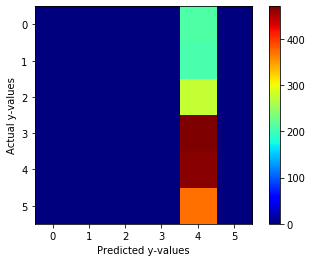

In [7]:
y_test_pred = esn.predict(x_test, transientTime=100, verbose=1)

classes = [0,1,2,3,4,5]
cm = confusion_matrix(unencode(y_test),unencode(y_test_pred),labels=classes)
plt.imshow(cm,cmap='jet')
plt.xlabel('Predicted y-values')
plt.ylabel('Actual y-values')
plt.colorbar()
plt.show()